# Carregar base de dados

In [1]:
import pandas as pd
df = pd.read_csv('fvm.csv')
df.head()

,liq,gor,wcut,lfg,whp,bhp
0,0.2,0.0,0.0,0.0,1.03,253.83
1,0.2,0.0,0.0,111111.1,1.03,10.44
2,0.2,0.0,0.0,222222.2,1.03,15.57
3,0.2,0.0,0.0,333333.3,1.03,20.76
4,0.2,0.0,0.0,444444.5,1.03,25.97


In [2]:
df.shape

(200000, 6)

# Divisão em treino e teste

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:5], df.loc[:,'bhp'], test_size=0.2)
print('input treino', x_train.shape)
print('input teste', x_test.shape)
print('output treino', y_train.shape)
print('output teste', y_test.shape)

input treino (160000, 5)
input teste (40000, 5)
output treino (160000,)
output teste (40000,)


In [4]:
x_train.head()

,liq,gor,wcut,lfg,whp
79406,15500.0,444.444,0.000000,666666.6,201.03
46244,4894.8,222.222,0.444444,444444.5,134.37
80006,0.2,0.000,0.000000,666666.6,267.70
187212,5710.6,222.222,0.111111,222222.2,601.03
35919,12236.9,1000.000,0.111111,999999.9,67.70


# Pré processamento: normalização

In [5]:
# modelo de normalização
from sklearn import preprocessing
preprocessParams = preprocessing.StandardScaler().fit(x_train)

In [6]:
# aplica normalização
x_train = preprocessParams.transform(x_train)
x_test = preprocessParams.transform(x_test)

In [7]:
x_train[0:5]

array([[ 1.646941  , -0.17496782, -1.56644114,  0.52187863, -0.52190498],
       [-0.60771655, -0.87175823, -0.1730247 , -0.17490287, -0.86947926],
       [-1.64830484, -1.56854864, -1.56644114,  0.52187863, -0.17427855],
       [-0.43427809, -0.87175823, -1.21808703, -0.871685  ,  1.56374928],
       [ 0.95320839,  1.56701134, -1.21808703,  1.56705135, -1.21710568]])

# Treinamento da Rede Neural

In [8]:
from keras import Model, Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


In [9]:
# Criação da Rede Neural
RN = Sequential()
RN.add(Dense(22,input_shape = x_train.shape[1:], activation = 'sigmoid'))
RN.add(Dense(1))

RN.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['mape'])
RN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 22)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 23        
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Treino
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode= 'min', patience = 50)
history = RN.fit(x_train, y_train, epochs = 20, validation_split=0.2, callbacks=[es]) 

Train on 128000 samples, validate on 32000 samples
Epoch 1/20
128000/128000 [==============================] - 5s 35us/step - loss: 3609.8680 - mape: 9.8846 - val_loss: 2258.8856 - val_mape: 9.7875
Epoch 2/20
128000/128000 [==============================] - 4s 34us/step - loss: 1881.3341 - mape: 7.7422 - val_loss: 1637.4194 - val_mape: 7.6820
Epoch 3/20
128000/128000 [==============================] - 4s 35us/step - loss: 1621.0341 - mape: 7.3542 - val_loss: 1440.5183 - val_mape: 6.7436
Epoch 4/20
128000/128000 [==============================] - 4s 34us/step - loss: 1529.5516 - mape: 7.1095 - val_loss: 1409.3781 - val_mape: 6.6225
Epoch 5/20
128000/128000 [==============================] - 4s 34us/step - loss: 1547.9527 - mape: 7.0538 - val_loss: 1535.0373 - val_mape: 6.7814
Epoch 6/20
128000/128000 [==============================] - 4s 35us/step - loss: 1605.9276 - mape: 7.0518 - val_loss: 1639.8751 - val_mape: 8.1687
Epoch 7/20
128000/128000 [==============================] - 4s 34us

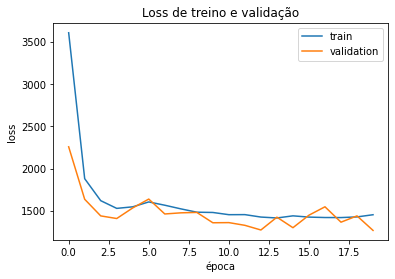

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

# Avaliar Proxy

In [17]:
# Avaliar base de teste
score = RN.evaluate(x_test, y_test, verbose = 0)
print('Test mse:', score[0])
print('Test mape:', score[1], '%')

Test mse: 1314.5219927490234
Test mape: 6.730976581573486 %


In [13]:
# Inferência
y_pred = RN.predict(x_test)
y_pred = y_pred[:,0]

In [14]:
# R quadrado (quanto mais próximo de 1, melhor a função aproxima o comportamento dos dados)
import numpy as np
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

0.9844274125279497

# Análise gráfica

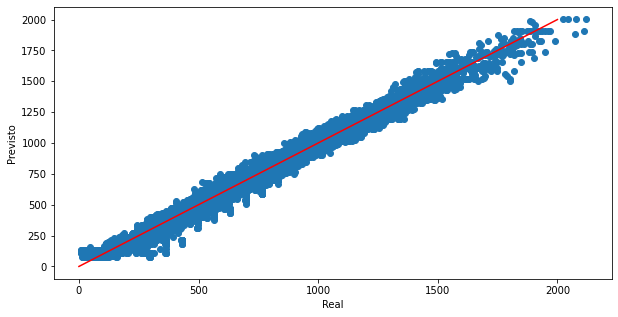

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.xlabel('Real')
plt.ylabel('Previsto')

a = np.arange(0, 2500, 1000)
b = a   # x = y
plt.plot(a, b, color='red');

In [20]:
y_pred.shape

(40000,)

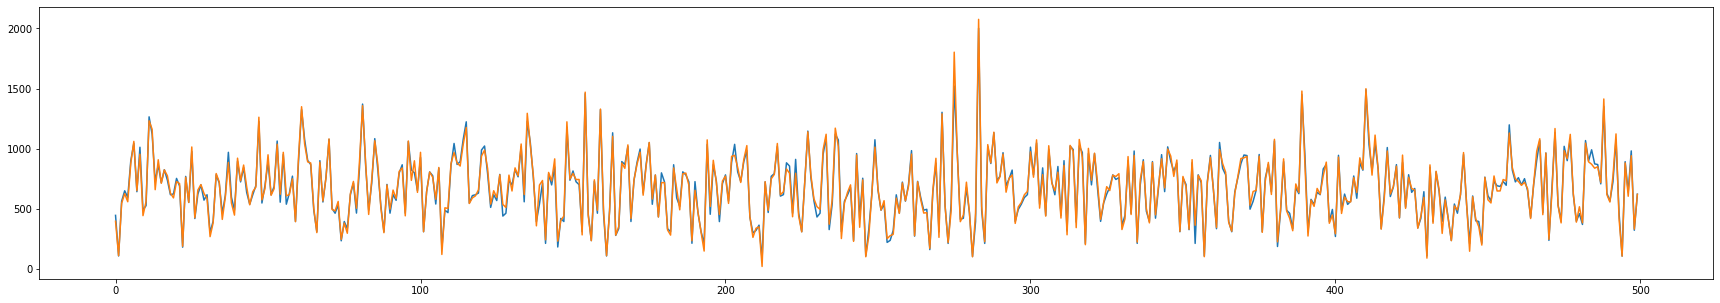

In [21]:
plt.figure(figsize=(30,5))
plt.plot(y_pred[0:500])
plt.plot(np.array(y_test[0:500]));